 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="https://gpu-nm.ddns.net/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/transfer_learning_catsdogs.ipynb#Cats-and-Dogs-(2):-Usando-uma-rede-pré-treinada" data-toc-modified-id="Cats-and-Dogs-(2):-Usando-uma-rede-pré-treinada-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cats and Dogs (2): Usando uma rede pré-treinada</a></span><ul class="toc-item"><li><span><a href="https://gpu-nm.ddns.net/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/transfer_learning_catsdogs.ipynb#Dataset" data-toc-modified-id="Dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="https://gpu-nm.ddns.net/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/transfer_learning_catsdogs.ipynb#Construção-da-rede-neural" data-toc-modified-id="Construção-da-rede-neural-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Construção da rede neural</a></span></li><li><span><a href="https://gpu-nm.ddns.net/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/transfer_learning_catsdogs.ipynb#Geração-de-features-convolucionais" data-toc-modified-id="Geração-de-features-convolucionais-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Geração de <em>features</em> convolucionais</a></span></li><li><span><a href="https://gpu-nm.ddns.net/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/transfer_learning_catsdogs.ipynb#Treinamento-da-camada-densa-utilizando-as-features" data-toc-modified-id="Treinamento-da-camada-densa-utilizando-as-features-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Treinamento da camada densa utilizando as <em>features</em></a></span></li><li><span><a href="https://gpu-nm.ddns.net/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/transfer_learning_catsdogs.ipynb#Fine-tunning" data-toc-modified-id="Fine-tunning-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Fine tunning</a></span></li><li><span><a href="https://gpu-nm.ddns.net/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/transfer_learning_catsdogs.ipynb#Atividade" data-toc-modified-id="Atividade-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Atividade</a></span></li><li><span><a href="https://gpu-nm.ddns.net/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/transfer_learning_catsdogs.ipynb#Aprendizados-com-este-notebook" data-toc-modified-id="Aprendizados-com-este-notebook-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Aprendizados com este notebook</a></span></li></ul></li></ul></div>

# Cats and Dogs (2): Usando uma rede pré-treinada

Este é o segundo dos dois notebooks sobre *data augmentation*, *transfer learning* e *fine tunning*.

Serão apresentadas abaixo as técnicas de *transfer learning* e *fine tunning*.

Neste notebook utilizam-se as camadas convolucionais de uma rede VGG já treinada para gerar as "características" das imagens e treina-se com uma rede neural densa de duas camadas. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import os, glob
import PIL.Image

import numpy as np
import torch
from torch import nn
import torch.utils.data
import torch.optim.lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision.models.resnet import BasicBlock

from lib import pytorch_trainer as ptt

## Dataset

In [2]:
class CatsDogsDataset(torch.utils.data.Dataset):
    def __init__(self, rootdir, train=True, transform=None):
        self.train = train
        self.transform = transform
        if self.train:
            self.dirpath = os.path.join(rootdir, 'train')
        else:
            self.dirpath = os.path.join(rootdir, 'validation')
        print(self.dirpath)
        self.l_filepaths = [fp for fp in sorted(glob.glob(os.path.join(self.dirpath, '**'), recursive=True))
                          if fp[-4:].lower() == '.jpg']
    def __len__(self):
        return len(self.l_filepaths)
    def __getitem__(self, index):
        fp = self.l_filepaths[index]
#         out = np.float32(os.path.basename(fp)[:3].lower() == 'dog')
        out = int(os.path.basename(fp)[:3].lower() == 'dog')
        inp = PIL.Image.open(fp)
        if self.transform is not None:
            inp = self.transform(inp)
        return inp, out
rootdir = '/data/datasets/catsdogs_fewsamples'
size_final = (150, 150)
transf_comp_train = torchvision.transforms.Compose([torchvision.transforms.Scale(size=size_final),
                                                    torchvision.transforms.ToTensor()])

transf_comp_valid = torchvision.transforms.Compose([torchvision.transforms.Scale(size=size_final),
                                                    torchvision.transforms.ToTensor()])

dataset_train = CatsDogsDataset(rootdir, train=True, transform=transf_comp_train)
dataset_valid = CatsDogsDataset(rootdir, train=False, transform=transf_comp_valid)

loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=len(dataset_train), shuffle=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
x_train, y_train = next(iter(loader_train))
x_valid, y_valid = next(iter(loader_valid))

/data/datasets/catsdogs_fewsamples/train
/data/datasets/catsdogs_fewsamples/validation


## Construção da rede neural
O *transfer learning* permite que utilizemos uma rede já treinada (a *ResNet34*, utilizando apenas uma parte convolucional da rede) para gerar um vetor de features. Essa primeira parte do modelo será chamado de *MyResNetConv*.

É possível utilizar esse vetor de features como entrada de uma rede densa simples, que terá como *output* a saída que será comparada com o resultado desejado. Essa parte final do modelo será chamada de *MyResNetDens*.

Essas duas partes serão integradas no modelo *MyResNet*, com o benefício de podermos utilizar a primeira parte para gerar as *features* convolucionais, que serão utilizadas no treinamento exclusivo da segunda parte.

In [3]:
class MyResNetConv(torchvision.models.ResNet):
    def __init__(self):
        super().__init__(BasicBlock, [3, 4, 6, 3])
        self.load_state_dict(torch.utils.model_zoo.load_url(
            'https://download.pytorch.org/models/resnet34-333f7ec4.pth'))
        del self.layer4
        del self.fc
        for param in self.parameters():
            param.requires_grad = False
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
#         x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

class MyResNetDens(nn.Module):
    def __init__(self):
        super().__init__()
        self.dens1 = nn.Linear(in_features=256, out_features=2)
        self.sigm1 = nn.Sigmoid()
    def forward(self, x):
        x = self.dens1(x)
        x = self.sigm1(x)
        return x

class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.mrnc = MyResNetConv()
        self.mrnd = MyResNetDens()
    def forward(self, x):
        x = self.mrnc(x)
        x = self.mrnd(x)
        return x

model = MyResNet()
if torch.cuda.is_available:
    model.cuda()
print(model)

# o0 = model(Variable(x_train[:17].cuda()))
# print(o0.data.size())

# o1 = model.mrnc(Variable(x_train[:17].cuda()))
# print(o1.data.size())

# o2 = model.dens(o1)
# print(o2.data.size())

MyResNet (
  (mrnc): MyResNetConv (
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
    (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (layer1): Sequential (
      (0): BasicBlock (
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): BasicBlock (
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride

## Geração de *features* convolucionais

In [4]:
inp_train = x_train
inp_valid = x_valid
if torch.cuda.is_available():
    inp_train = inp_train.cuda()
    inp_valid = inp_valid.cuda()
inp_train = Variable(inp_train)
inp_valid = Variable(inp_valid)

feat_train = model.mrnc(inp_train).data
feat_valid = model.mrnc(inp_valid).data

print(feat_train.size())
print(feat_valid.size())

torch.Size([2000, 256])
torch.Size([800, 256])


## Treinamento da camada densa utilizando as *features*

In [5]:
n_epochs = 50
optm = torch.optim.Adam(params=model.mrnd.parameters(), lr=1e-4)
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10, gamma=0.75)
cb_chkpt = ptt.ModelCheckpoint('../../models/transfer_learning_catsdogs', reset=True, verbose=1)

trainer = ptt.DeepNetTrainer(model         = model.mrnd,
                             criterion     = nn.CrossEntropyLoss(),
                             optimizer     = optm,
                             lr_scheduler  = schd,
                             callbacks = [cb_chkpt, ptt.AccuracyMetric(), ptt.PrintCallback()])

train = True
if train:
    trainer.fit(n_epochs   = n_epochs,
                Xin        = feat_train,
                Yin        = y_train,
                shuffle    = True,
                batch_size = 100,
                valid_data = (feat_valid, y_valid))
# else:
#     trainer.load_state('/data/models/data_augmentation_catsdogs')

Start training for 50 epochs
  1:   0.8s   T: 0.69537 0.50100   V: 0.69536 0.49250 best
  2:   0.0s   T: 0.69413 0.51650   V: 0.69415 0.51125 best
  3:   0.0s   T: 0.69293 0.53550   V: 0.69297 0.54625 best
  4:   0.0s   T: 0.69180 0.56600   V: 0.69180 0.58125 best
  5:   0.0s   T: 0.69062 0.62050   V: 0.69067 0.62125 best
  6:   0.0s   T: 0.68949 0.68050   V: 0.68953 0.65875 best
  7:   0.0s   T: 0.68836 0.74450   V: 0.68839 0.73750 best
  8:   0.0s   T: 0.68723 0.79800   V: 0.68725 0.79375 best
  9:   0.0s   T: 0.68612 0.82000   V: 0.68613 0.83500 best
 10:   0.0s   T: 0.68513 0.83950   V: 0.68528 0.84375 best
 11:   0.0s   T: 0.68431 0.84700   V: 0.68446 0.84750 best
 12:   0.0s   T: 0.68346 0.85650   V: 0.68362 0.85875 best
 13:   0.0s   T: 0.68265 0.85900   V: 0.68279 0.86000 best
 14:   0.0s   T: 0.68182 0.86750   V: 0.68196 0.86750 best
 15:   0.0s   T: 0.68100 0.86400   V: 0.68114 0.85250 best
 16:   0.0s   T: 0.68017 0.86400   V: 0.68031 0.86875 best
 17:   0.0s   T: 0.67938 0.

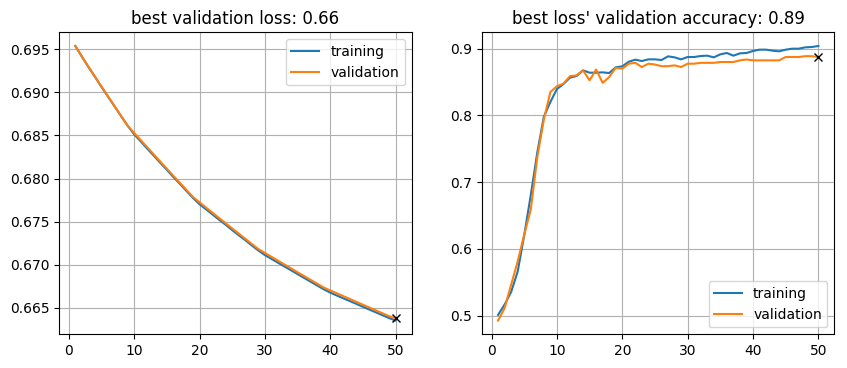

In [6]:
idx = np.argmin(trainer.metrics['valid']['losses'])
a_epochs = np.arange(1, 1 + len(trainer.metrics['valid']['acc']))
fig = plt.figure(figsize=(10, 4), dpi=100)
ax = fig.add_subplot(1, 2, 1)
ax.plot(a_epochs, trainer.metrics['train']['losses'], label='training')
ax.plot(a_epochs, trainer.metrics['valid']['losses'], label='validation')
ax.set_title('best validation loss: {:.2f}'.format(trainer.metrics['valid']['losses'][idx]))
ax.plot(idx + 1, trainer.metrics['valid']['losses'][idx], 'kx')
ax.legend()
ax.grid(True)

ax = fig.add_subplot(1, 2, 2)
ax.plot(a_epochs, trainer.metrics['train']['acc'], label='training')
ax.plot(a_epochs, trainer.metrics['valid']['acc'], label='validation')
ax.set_title('best loss\' validation accuracy: {:.2f}'.format(trainer.metrics['valid']['acc'][idx]))
ax.plot(idx + 1, trainer.metrics['valid']['acc'][idx], 'kx')
ax.legend()
ax.grid(True)
plt.show()

## Fine tunning
É possível ainda refazer o treinamento da camada densa junto ao último bloco convolucional da rede *ResNet*, mantendo todas as outras camadas fixas e utilizando um *learning rate* com valor bem baixo.

In [8]:
for param in model.mrnc.layer3[5].parameters():
    param.requires_grad = True
for param in model.mrnd.dens1.parameters():
    param.requires_grad = True

batch_size = 40
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

n_epochs = 50
optm = torch.optim.Adam(params=model.mrnd.parameters(), lr=1.e-9)
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10, gamma=0.75)
cb_chkpt = ptt.ModelCheckpoint('../../models/transfer_learning_catsdogs', reset=True, verbose=1)

trainer = ptt.DeepNetTrainer(model         = model,
                             criterion     = nn.CrossEntropyLoss(),
                             optimizer     = optm,
                             lr_scheduler  = schd,
                             callbacks = [cb_chkpt, ptt.AccuracyMetric(), ptt.PrintCallback()])

train = True
if train:
    trainer.fit_loader(n_epochs, loader_train, loader_valid)
# else:
#     trainer.load_state('/data/models/data_augmentation_catsdogs')

Start training for 50 epochs
  1:   7.7s   T: 0.66391 0.90450   V: 0.66384 0.89500 best
  2:   7.7s   T: 0.66393 0.89850   V: 0.66394 0.89125 
  3:   7.8s   T: 0.66380 0.90050   V: 0.66387 0.88625 
  4:   7.8s   T: 0.66406 0.89800   V: 0.66388 0.88500 
  5:   7.8s   T: 0.66376 0.89750   V: 0.66395 0.89000 
  6:   7.8s   T: 0.66374 0.90150   V: 0.66388 0.89000 
  7:   7.8s   T: 0.66380 0.90150   V: 0.66377 0.88625 best
  8:   7.8s   T: 0.66382 0.90000   V: 0.66380 0.89250 
  9:   7.8s   T: 0.66387 0.90100   V: 0.66386 0.88375 
 10:   7.8s   T: 0.66381 0.90200   V: 0.66402 0.89000 
 11:   7.8s   T: 0.66390 0.89800   V: 0.66403 0.88500 
 12:   7.8s   T: 0.66389 0.90150   V: 0.66368 0.89125 best
 13:   7.8s   T: 0.66377 0.90000   V: 0.66382 0.88875 
 14:   7.8s   T: 0.66380 0.90100   V: 0.66393 0.88625 
 15:   7.8s   T: 0.66405 0.90000   V: 0.66395 0.89375 
 16:   7.8s   T: 0.66388 0.90450   V: 0.66387 0.88625 
 17:   7.8s   T: 0.66382 0.90100   V: 0.66398 0.88750 
 18:   7.8s   T: 0.66399

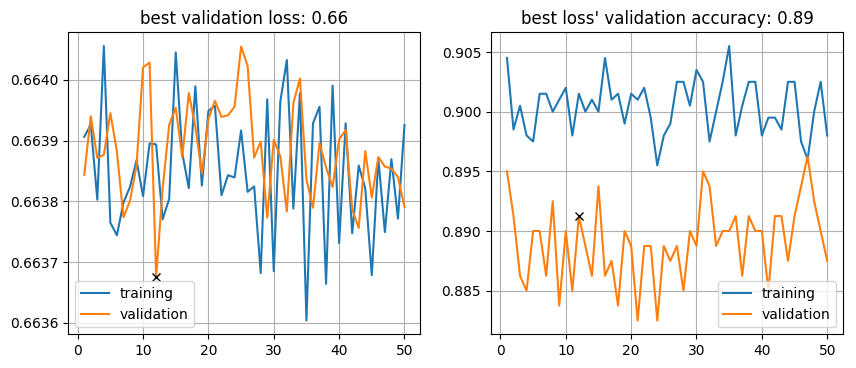

In [9]:
idx = np.argmin(trainer.metrics['valid']['losses'])
a_epochs = np.arange(1, 1 + len(trainer.metrics['valid']['acc']))
fig = plt.figure(figsize=(10, 4), dpi=100)
ax = fig.add_subplot(1, 2, 1)
ax.plot(a_epochs, trainer.metrics['train']['losses'], label='training')
ax.plot(a_epochs, trainer.metrics['valid']['losses'], label='validation')
ax.set_title('best validation loss: {:.2f}'.format(trainer.metrics['valid']['losses'][idx]))
ax.plot(idx + 1, trainer.metrics['valid']['losses'][idx], 'kx')
ax.legend()
ax.grid(True)

ax = fig.add_subplot(1, 2, 2)
ax.plot(a_epochs, trainer.metrics['train']['acc'], label='training')
ax.plot(a_epochs, trainer.metrics['valid']['acc'], label='validation')
ax.set_title('best loss\' validation accuracy: {:.2f}'.format(trainer.metrics['valid']['acc'][idx]))
ax.plot(idx + 1, trainer.metrics['valid']['acc'][idx], 'kx')
ax.legend()
ax.grid(True)
plt.show()

## Aprendizados com este notebook

1. O uso de uma rede pré-treinada com pesos utilizados em competições, serve para a extração eficiente de atributos das imagens de um modo geral. 
2. Os *features* gerados pela rede ResNet podem ser utilizados para classificação utilizando qualquer classificador. Neste caso utilizamos um classificador por rede neural densa. Desta forma, podemos em seguida realizar o *fine tunning* fazendo também o treinamento de mais camadas da rede.
